In [1]:
#technical libs
import pandas as pd
import numpy as np
import json
import requests
import re

from datetime import timedelta
import datetime
from datetime import date


import psycopg2

ModuleNotFoundError: No module named 'psycopg2'

In [2]:
#math libs
import math

import itertools
from itertools import product

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
import collections as co

from scipy import stats
import statsmodels.api as sm


def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
#for visualisation
%pylab inline
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
sns.set(style="white", color_codes=True)

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
init_notebook_mode(connected=True)


def plot_right_now(df = None, dim = 'sum_transactions'):
    for i in ts_df.project.unique():

        print('project:',i)

        fig = go.Figure(data=go.Scatter(x=ts_df[(ts_df.project == i)].date
                                        , y=ts_df[(ts_df.project == i)][dim]
                                       , name="project:"+str(i)
                                        ,line_shape='spline'

                                       )
                       )


        fig.show()
    

Populating the interactive namespace from numpy and matplotlib


C:\Users\Anton\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


ModuleNotFoundError: No module named 'plotly'

In [4]:
ts_df = pd.read_csv('./data2/timeseries.tsv' , sep = '\t' , header = None)
ts_df.columns = ['project' , 'date' , 'count_transactions' , 'sum_transactions']

In [5]:
ts_df.shape

(5482, 4)

In [6]:
ts_df.head()

,project,date,count_transactions,sum_transactions
0,1,2016-01-01,119,8108.62
1,1,2016-01-02,139,8715.97
2,1,2016-01-03,130,7565.75
3,1,2016-01-04,146,8159.03
4,1,2016-01-05,137,7591.57


In [27]:
#в датасете собрана информация по 5 проектам с 01.01.2016 по 01.06.2019
#ваша задача
#1 - Провести визуальный анализ временных рядов
#2 - Разработать код для препроцессинга данных для создания модели прогнозирования временных рядов
#3 - Разработать модель прогноза временных рядов
#4 - Настроить кросс валидацию модели
#5 - Сделать прогноз суммы транзакций с шагом в день на весь месяц 06.2019 и визуализировать
#6 - сделать прогноз суммы транзакций с шагом в день на весь месяц 12.2015 и визуализировать
#7 - результаты решений 5 и 6 сохранить в csv файл timeseries_result.csv с колонками - project,date,sum_transactions.
#сохранить в csv только данные  за 06.2019 и 12.2015 с шагом в день

In [28]:
ts_df.dtypes

project                 int64
date                   object
count_transactions      int64
sum_transactions      float64
dtype: object

In [7]:
ts_df['date'] = pd.to_datetime(ts_df['date'])

TypeError: cannot convert the series to <class 'int'>

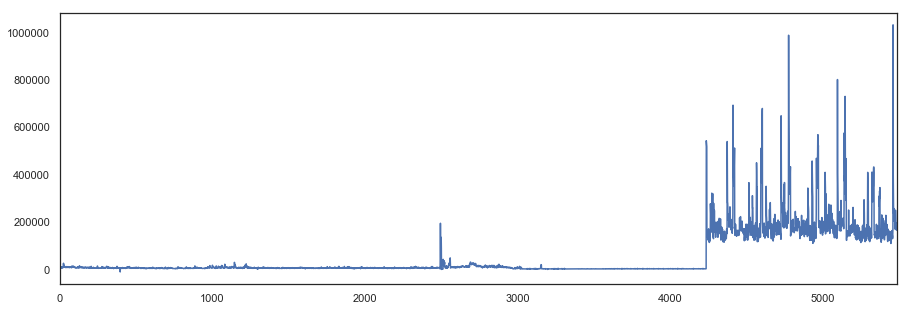

In [11]:
#проведем визуальный анализ
plot_right_now(df = ts_df, dim = 'sum_transactions')

In [31]:
#видим большие размерности  и есть значения меньше нуля, посмотрим сколько их
print(ts_df[(ts_df.sum_transactions < 0)].shape[0] / ts_df.shape[0])
#менее процента, явно какая то аномалия, заменим их нулями

ts_df.sum_transactions = np.clip(ts_df.sum_transactions, 0, ts_df.sum_transactions.max())

0.002918642831083546


In [32]:
#проведем визуальный анализ

for i in ts_df.project.unique():

    print('project:',i)
    
    fig = go.Figure(data=go.Scatter(x=ts_df[(ts_df.project == i)].date
                                    , y=ts_df[(ts_df.project == i)].sum_transactions
                                   , name="project:"+str(i)
                                    ,line_shape='spline'
                                  
                                   )
                   )
    

    fig.show()

project: 1


project: 2


project: 3


project: 4


project: 5


In [33]:
#видно у некоторых наличие аномальных значений, которые мы не сможем предсказать,
#вроде как сильных отклонений ет, давайте посмотрим по выявлению аномалий на правиле 3 сигма по быстрому

def thr_sigma(arr):
    mean_arr = np.mean(arr)
    
    squares = (arr - mean_arr)** 2
    
    sigma = sum(squares) / len(squares)
    
    sigma = np.round(np.sqrt(sigma) , 2)
    
    border = np.mean(arr) + 3*sigma
    
    return border


    

for i in ts_df.project.unique():
    border = thr_sigma(ts_df[(ts_df.project == i)].sum_transactions)
    
    more_sigmas = ts_df[(ts_df.project == i) & (ts_df.sum_transactions > border)].shape[0] / ts_df[(ts_df.project == i)].shape[0] 
    
    print('percent more sigma {0}%'.format(np.round(  more_sigmas*100 , 2)) )
    
    #будем учитывать их как максимальные значения
    proj_ind = ts_df[(ts_df.project == i)].index
    ts_df.loc[proj_ind , 'sum_transactions'] = np.clip(ts_df[(ts_df.project == i)].sum_transactions, 0, border)

    

percent more sigma 1.76%
percent more sigma 1.61%
percent more sigma 0.98%
percent more sigma 1.19%
percent more sigma 2.41%


In [34]:
#проведем визуальный анализ
plot_right_now(df = ts_df, dim = 'sum_transactions')

project: 1


project: 2


project: 3


project: 4


project: 5


In [ ]:
#следующие выводы:
#проект 1 - был сначала понижающий тренд, потом стабилизировался после 22 августа примерно, нужно стабилизировать тренд
#проект 2 - сложно сказать что тут вобще происходит
#проект 3 - видно проект умирает можно спокойно прогнозировать с 30 декабря или с марта 2019 годов
#проект 4 - явно видна сезонность и стабильный трафик можно взять статистику с января 2018 года
#проект 5 видны явные сезонные вещи сложно сказать что это пока

In [35]:
#проанализируем стационарность рядов
for i in ts_df.project.unique():
    print("project:%i Критерий Дики-Фуллера: p=%f" % (i ,sm.tsa.stattools.adfuller(ts_df[(ts_df.project == i)].sum_transactions)[1]))
    
    
#видим - явно в третьем проекте влияние тренда, в четвертом, как и визуально выявили, первый проект под вопросом, однако мы визуально видим тренл

project:1 Критерий Дики-Фуллера: p=0.005182
project:2 Критерий Дики-Фуллера: p=0.000163
project:3 Критерий Дики-Фуллера: p=0.168153
project:4 Критерий Дики-Фуллера: p=0.051609
project:5 Критерий Дики-Фуллера: p=0.000000


In [36]:
#давайте стабилизируем дисперсию преобразованием бокса кокса
ts_df.sum_transactions += 1
ts_df['sum_transactions_cox'] = np.nan

for i in ts_df.project.unique():
        
    ts_df_p = ts_df[(ts_df.project == i)][:]
    proj_ind = ts_df_p.index
    
    ts_df_p['sum_transactions_cox'] , lmbda = stats.boxcox(ts_df_p.sum_transactions)
    
    ts_df.loc[proj_ind , 'sum_transactions_cox'] = ts_df_p['sum_transactions_cox']
    

In [37]:
#давайте стабилизируем тренд единичным дифференцированием
ts_df['sum_transactions_cox_1diff'] = np.nan

for i in ts_df.project.unique():
    ts_df_p = ts_df[(ts_df.project == i)][:]
    proj_ind = ts_df_p.index
    
    ts_df_p['sum_transactions_cox_1diff'] = ts_df_p.sum_transactions_cox - ts_df_p.sum_transactions_cox.shift(1)
    
    ts_df.loc[proj_ind , 'sum_transactions_cox_1diff'] = ts_df_p['sum_transactions_cox_1diff']
    
ts_df.dropna(inplace = True)

In [38]:
#проведем визуальный анализ

plot_right_now(df = ts_df, dim = 'sum_transactions_cox_1diff')

project: 1


project: 2


project: 3


project: 4


project: 5


In [39]:
#видим что дисперсия пляшет, проверим по критерию Стьюдента
def student(arr):
    student = stats.ttest_1samp(arr, 0)[1]
    
    return student

for i in ts_df.project.unique():
    print("project:%i Критерий Стьюдента: p=%f" % (i ,student(ts_df[(ts_df.project == i)].sum_transactions_cox_1diff)))
    
#однако критерий отвергает какое либо значимое смещение


project:1 Критерий Стьюдента: p=0.984521
project:2 Критерий Стьюдента: p=0.949079
project:3 Критерий Стьюдента: p=0.936456
project:4 Критерий Стьюдента: p=0.854873
project:5 Критерий Стьюдента: p=0.931388




гиперпараметры верменного ряда 

d — порядок интегрированного ряда 
Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка. Иначе - это минимальное количество периодов, необходимое для приведения к стационарному виду.

![title](images/pq.png)


p — порядок компоненты AR - 
![title](images/p.png)



q — порядок компонетны MA
![title](images/q.png)


D - определет порядок интегрированности сезонной разности, т.е. в нашем случае он равен 1

Q и p
![title](images/QP.png)

project: 1


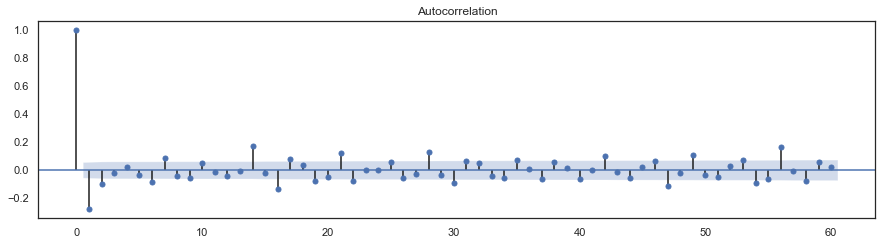

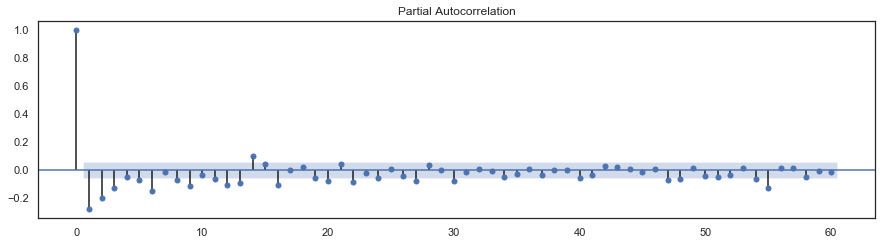

project: 2


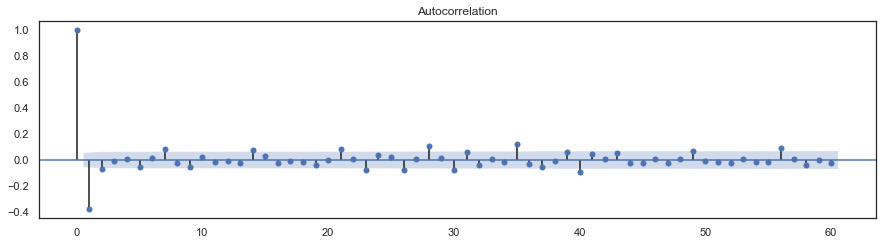

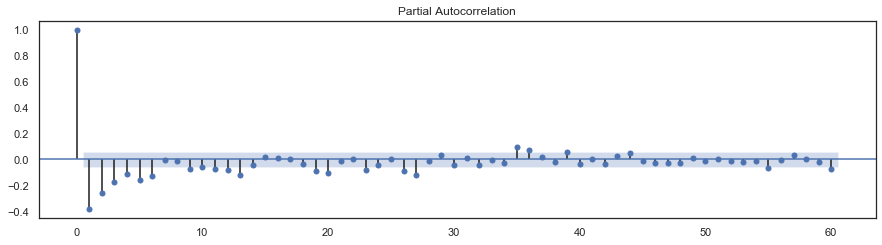

project: 3


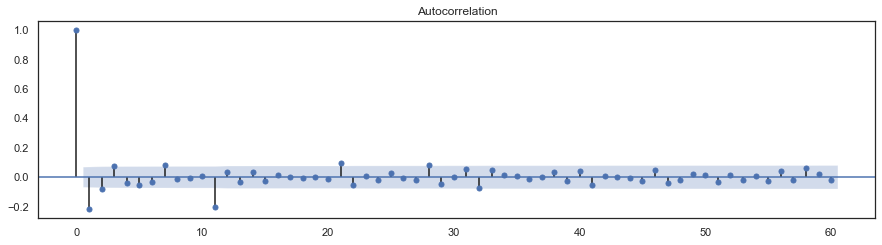

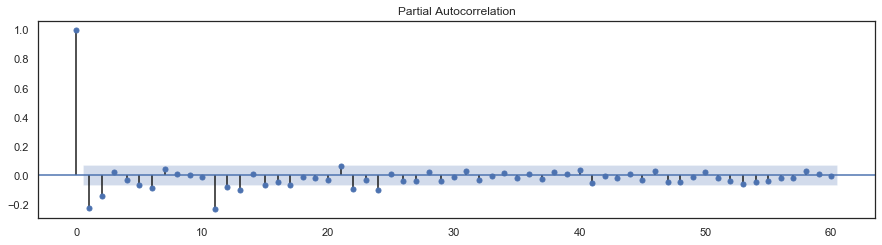

project: 4


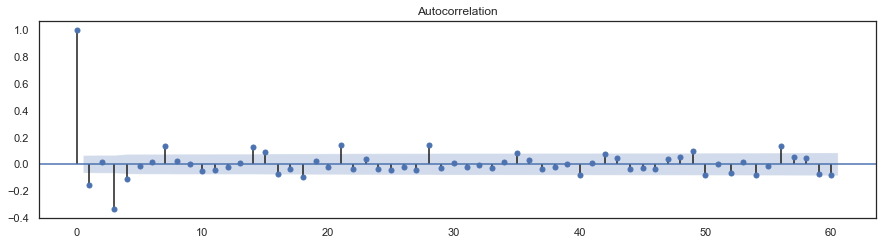

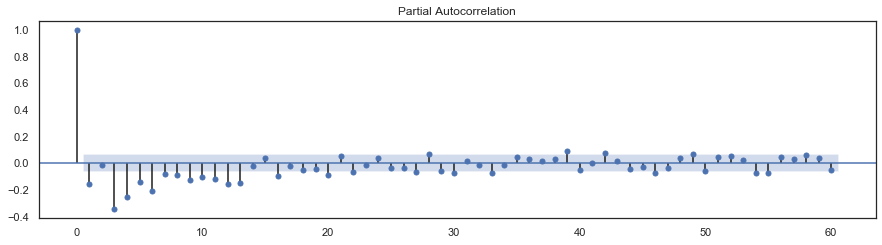

project: 5


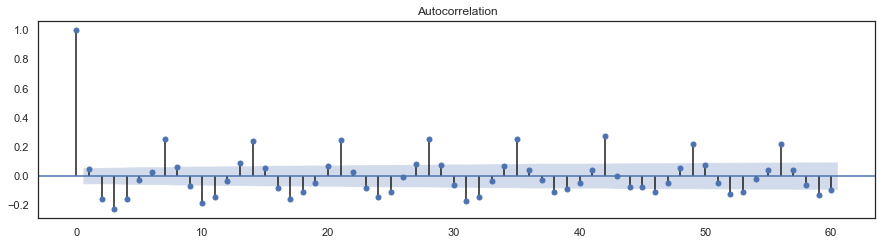

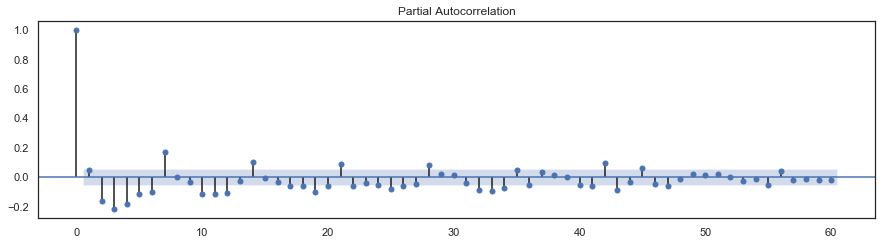

In [40]:
#проанализируем корролелограммы

for i in ts_df.project.unique():
    print('project:',i)
    
    
    
    plt.figure(figsize(15,8))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(ts_df[(ts_df.project == i)].sum_transactions_cox_1diff[1:].values.squeeze(), lags=60, ax=ax )
    pylab.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(ts_df[(ts_df.project == i)].sum_transactions_cox_1diff[1:].values.squeeze(), lags=60, ax=ax)
    pylab.show()

In [ ]:
#оо чудненько мы прямо таки где то видим зависимости!
#зададим область поиска для каждого проекта персональную

In [41]:
#find best lag for model
def get_main_lags(df_contr= None, stable_column= None, shift_days= None):
    #calc acf values and levels
    acf_values , confint = sm.tsa.stattools.acf(df_contr[stable_column][shift_days:].values.squeeze() , alpha=0.05)
    top_level_acf = confint[:, 1] - acf_values
    low_level_acf = confint[:, 0] - acf_values

    #calc pacf values and levels
    pacf_values , p_confint = sm.tsa.stattools.pacf(df_contr[stable_column][shift_days:].values.squeeze() , alpha=0.05)
    top_level_pacf = p_confint[:, 1] - pacf_values
    low_level_pacf = p_confint[:, 0] - pacf_values

    #get important autocorrelation lags
    acf_main_lags = []
    for acf , top , low , i in zip (acf_values , top_level_acf , low_level_acf , range(len(acf_values))):
        if acf > top  or acf < low :
            acf_main_lags.append(i)
            
    #get important partial autocorrelation lags
    pacf_main_lags = []
    for pacf , ptop , plow ,pi in zip (pacf_values , top_level_pacf , low_level_pacf, range(len(pacf_values))):
        if pacf > ptop  or pacf < plow :
            pacf_main_lags.append(pi)


    return acf_main_lags , pacf_main_lags



In [42]:
lags_hyperparams = {}

for i in ts_df.project.unique():
    
    ts_df_p = ts_df[(ts_df.project == i)][:]
    
    acf_main_lags , pacf_main_lags = get_main_lags(df_contr= ts_df_p
                                                               , stable_column= 'sum_transactions_cox_1diff'
                                                               , shift_days= 1)
    lags_hyperparams[i] = {'acf' : acf_main_lags
                          ,'pacf':pacf_main_lags}
    
lags_hyperparams

{1: {'acf': [0, 1, 2, 6, 7, 14, 16, 17, 19, 21, 22, 28, 30, 35],
  'pacf': [0,
   1,
   2,
   3,
   5,
   6,
   8,
   9,
   11,
   12,
   13,
   14,
   16,
   19,
   20,
   22,
   24,
   27,
   30,
   40]},
 2: {'acf': [0, 1, 2, 7, 14, 21, 23, 26, 28, 30, 35, 40],
  'pacf': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   9,
   10,
   11,
   12,
   13,
   19,
   20,
   23,
   26,
   27,
   35,
   36,
   39]},
 3: {'acf': [0, 1, 2, 3, 7, 11, 21, 28],
  'pacf': [0, 1, 2, 6, 11, 12, 13, 22, 24]},
 4: {'acf': [0, 1, 3, 4, 7, 14, 15, 18, 21, 28, 40],
  'pacf': [0,
   1,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   16,
   20,
   22,
   27,
   30,
   33,
   39]},
 5: {'acf': [0,
   2,
   3,
   4,
   7,
   9,
   10,
   11,
   13,
   14,
   16,
   17,
   18,
   21,
   23,
   24,
   25,
   27,
   28,
   31,
   32,
   35,
   38,
   39],
  'pacf': [0,
   2,
   3,
   4,
   5,
   6,
   7,
   10,
   11,
   12,
   14,
   17,
   18,
   19,
   20,
   21,
   22,
   25,
   26,
   28,

In [43]:
#у многих получается много
#давайте оставим только первые N элементов для тестирования нашего подхода
def get_interest_qp(n_best= 3, shift_days= 2, acf_main_lags= None, pacf_main_lags= None , base_append = 3):
    #choose best Q,q,P,p
    Qs = []
    qs = []
    Ps = []
    ps = []

    #find Q and q from ACF
    for acf_l in acf_main_lags:
        
        #Qs -> Q * S = acf_l 
        if acf_l % shift_days == 0:
            Qs.append(int(acf_l / shift_days) )
            
        #qs -> max(acf_l)
        qs.append(acf_l)
        

    #find P and p from PACF
    for pacf_l in pacf_main_lags:

        #Ps -> P * S = pacf_l 
        if pacf_l % shift_days == 0:
            Ps.append(int(pacf_l / shift_days) )

        #ps -> max(pacf_l)
        ps.append(pacf_l)

    #stay best n
    if len(Qs) > n_best:
        Qs = Qs[-n_best:]
    if len(Ps) > n_best:
        Ps = Ps[-n_best:]
    if len(qs) > n_best:
        qs = qs[-n_best:]
    if len(ps) > n_best:
        #ps = ps[-n_best:]
        ps = ps[:n_best]

    #if lonely one then base append
    Qs.append(base_append) if len(Qs) == 1 else next
    Ps.append(base_append) if len(Ps) == 1 else next
    qs.append(base_append) if len(qs) == 1 else next
    ps.append(base_append) if len(ps) == 1 else next


    return Qs, qs, Ps, ps


In [44]:
N = 3
for i in ts_df.project.unique():
    
    ts_df_p = ts_df[(ts_df.project == i)][:]
    
    Qs, qs, Ps, ps = get_interest_qp(n_best= N
                                     , shift_days= 1
                                     , acf_main_lags= lags_hyperparams[i]['acf']
                                     , pacf_main_lags= lags_hyperparams[i]['pacf'])
    
    lags_hyperparams[i]['Qs'] = Qs
    lags_hyperparams[i]['qs'] = qs
    lags_hyperparams[i]['Ps'] = Ps
    lags_hyperparams[i]['ps'] = ps

In [45]:
lags_hyperparams[1]['Qs']

[28, 30, 35]

In [46]:
#окей найдем теперь лучшие гиперпараметры для наших временных рядов
#мы же понимаем что в зависимости от длины прогноза качество прогнозируемых рядов может быть разное
#мы хотим прогнозировать на месяц, давайте исчислять 4 полными неделями 
#также мы видим, что во времени нет такого временного ряда, который был бы неизбежен все время, 
#давайте попробуем строить временные ряды на основаннии данных пол года так как какое-то критичное изменение есть в 3 проекте, умирает с начала 2019
d = 1
D = 1
cnt_weeks_to_self_predict = 4
look_period = 270

In [47]:
def trendline(data, order=1):
    coeffs = np.polyfit(np.arange(data.shape[0]), list(data), order)
    slope = coeffs[-2]
    slope = np.log10(slope)
    return float(slope)

#find best Q, q, P, p
def get_best_qp(df_contr,Qs,qs,Ps,ps,d=1,D=1,cnt_weeks_to_self_predict= 2,look_period=None,shift_days=None
               ,hard_block = True):
    
    #generate allcombinations of ps, qs, Ps, Qs
    parameters = itertools.product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)


    results = []
    best_aic = float("inf")
    best_rmse = float("inf")
    best_total_metric = float("inf")

    warnings.filterwarnings('ignore')
    step = 0
    
    if hard_block:
        parameters_list = parameters_list[:4]

    print(len(parameters_list))
    for param in parameters_list:
        print(param)

        start_p = df_contr.shape[0] - look_period -cnt_weeks_to_self_predict*7
        end_p = df_contr.shape[0]  -cnt_weeks_to_self_predict*7
        
        
        #try except because of for some combinations not valid for SARIMAX model
        try:
            model=sm.tsa.statespace.SARIMAX(df_contr.sum_transactions[start_p:end_p]
                                            , order=(param[0] #p
                                            , d
                                            , param[1]),  #q
                                            seasonal_order=(param[2] #P
                                                            , D
                                                            , param[3] #Q
                                                            , int(shift_days)
                                                           )
                                           ).fit(disp=-1)
        #on error go to next parametrs
        except ValueError:
            continue
            
        #calc aic value of model
        aic = model.aic

        #calc model rmse and ae
        
        pred_vals = model.predict(start = end_p, end = df_contr.shape[0], dynamic=False)
        pred_vals[pred_vals < 0] = 0

        rmse_df = pd.concat([pred_vals, df_contr['sum_transactions']], axis=1, join='inner')
        rmse_df.columns = ['pred_sum_usd' , 'true_sum_usd']
        model_rmse = np.sqrt(np.mean((rmse_df.pred_sum_usd-rmse_df.true_sum_usd)**2))
        model_ae = sum((rmse_df.pred_sum_usd-rmse_df.true_sum_usd))

        model_mape = abs(rmse_df.true_sum_usd.sum() - rmse_df.pred_sum_usd.sum()) / rmse_df.true_sum_usd.sum()
        
        #calc average real value
        avg_true_sum = round(rmse_df['true_sum_usd'].mean() , 2)

        #calc sum real and predict value
        true_sum = round(rmse_df['true_sum_usd'].sum() , 2)
        predict_sum = round(rmse_df['pred_sum_usd'].sum() , 2)


        #calc total metric
        #v1 aic * rmse 
        #total_metric = aic * model_rmse
        #v2 change rmse to mape
        total_metric = aic * model_mape


        #make additional metrics of: 
        #first_5_mean (mean first 5 element) 
        #first_5_diff (diff first 5 element)
        #last_5_mean (mean last 5 element)
        #last_5_diff (diff last 5 element)
        #last_to_first_5_mean (last_5_mean / first_5_mean)
        #last_to_first_5_diff (last_5_diff / first_5_diff)
        #trend
        #trend_diff
        #for cases with predictions -> *_p at end . for cases with true values -> *_t at end
        first_5_mean_t = round ( np.mean(rmse_df.head()['true_sum_usd']) , 2)
        first_5_mean_p = round( np.mean(rmse_df.head()['pred_sum_usd']) , 2)
        if first_5_mean_t != 0:
            first_5_diff = round( first_5_mean_p / first_5_mean_t , 2)
        else:
            first_5_diff = 0.
        last_5_mean_t = round( np.mean(rmse_df.tail()['true_sum_usd']) , 2)
        last_5_mean_p = round( np.mean(rmse_df.tail()['pred_sum_usd']) , 2)
        if last_5_mean_t != 0:
            last_5_diff = round( last_5_mean_p / last_5_mean_t , 2)
        else:
            last_5_diff = 0.

        if first_5_mean_t != 0:
            last_to_first_5_mean_t = round( last_5_mean_t / first_5_mean_t , 2)
        else: 
            last_to_first_5_mean_t = 0.

        if first_5_mean_p != 0:
            last_to_first_5_mean_p = round( last_5_mean_p / first_5_mean_p , 2)
        else:
            last_to_first_5_mean_p = 0.

        if last_to_first_5_mean_t != 0:
            last_to_first_5_diff = round( last_to_first_5_mean_p /  last_to_first_5_mean_t , 2)
        else:
            last_to_first_5_diff = 0.



        #actually dont need
        #save best model, aic, param
        if total_metric < best_total_metric:
            best_model = model
            best_aic = aic
            best_rmse = model_rmse
            best_ae = model_ae
            best_total_metric = total_metric
            best_param = param

        
        #append to main results
        results.append([param, model.aic , model_rmse, model_ae  , total_metric, avg_true_sum , true_sum , predict_sum
                        , first_5_mean_t , first_5_mean_p , first_5_diff , last_5_mean_t , last_5_mean_p , last_5_diff , last_to_first_5_mean_t , last_to_first_5_mean_p , last_to_first_5_diff 
                        ])

        
        
    warnings.filterwarnings('default')

    #create df with main info of model results
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'rmse', 'ae' , 'total_metric', 'avg_true_sum' , 'true_sum' , 'predict_sum'
                            , 'first_5_mean_t' , 'first_5_mean_p' , 'first_5_diff' , 'last_5_mean_t' , 'last_5_mean_p' , 'last_5_diff' , 'last_to_first_5_mean_t' , 'last_to_first_5_mean_p' , 'last_to_first_5_diff' 
                            ]

    #get best qp params tuple
    best_df = result_table.sort_values(by = 'total_metric', ascending=True).reset_index(drop=True).loc[0]

    best_qp = best_df['parameters']
    best_aic = round(best_df['aic'],3)
    best_rmse = round(best_df['rmse'],3)
    best_ae = round(best_df['ae'],3)
    best_total_metric = round(best_df['total_metric'],3)
    best_avg_true_sum = best_df['avg_true_sum']

    best_true_sum = best_df['true_sum']
    best_predict_sum = best_df['predict_sum']


    best_first_5_mean_t = best_df['first_5_mean_t']
    best_first_5_mean_p = best_df['first_5_mean_p']
    best_first_5_diff = best_df['first_5_diff']
    best_last_5_mean_t = best_df['last_5_mean_t']
    best_last_5_mean_p = best_df['last_5_mean_p']
    best_last_5_diff = best_df['last_5_diff']
    best_last_to_first_5_mean_t = best_df['last_to_first_5_mean_t']
    best_last_to_first_5_mean_p = best_df['last_to_first_5_mean_p']
    best_last_to_first_5_diff = best_df['last_to_first_5_diff']




    #make dict to return
    best_qp_dict = {'p': best_qp[0], 'q': best_qp[1], 'P': best_qp[2], 'Q': best_qp[3], 'AIC': best_aic, 'RMSE': best_rmse, 'AE':best_ae , 'TM': best_total_metric, 'AVGSUM': best_avg_true_sum 
                    
                    ,'true_sum' : best_true_sum
                    ,'predict_sum' : best_predict_sum

                    , 'first_5_mean_t' : best_first_5_mean_t 
                    , 'first_5_mean_p' : best_first_5_mean_p 
                    , 'first_5_diff' : best_first_5_diff 
                    , 'last_5_mean_t' : best_last_5_mean_t 
                    , 'last_5_mean_p' : best_last_5_mean_p 
                    , 'last_5_diff' : best_last_5_diff 
                    , 'last_to_first_5_mean_t' : best_last_to_first_5_mean_t 
                    , 'last_to_first_5_mean_p' : best_last_to_first_5_mean_p 
                    , 'last_to_first_5_diff' : best_last_to_first_5_diff 

                    }


    return best_qp_dict

In [48]:
#давайте далее разберем для одного проекта, кому будет интересно можете дома разобрать для всех
#зачем - время обучения одной модели

i = 4
df_contr =  ts_df[(ts_df.project == i)].reset_index()[:]
Qs = lags_hyperparams[1]['Qs']
qs = lags_hyperparams[1]['qs']
Ps = lags_hyperparams[1]['Ps']
ps = lags_hyperparams[1]['ps']


In [ ]:


best_qp_dict = get_best_qp(df_contr,Qs,qs,Ps,ps,d=1,D=1
                                       ,cnt_weeks_to_self_predict= cnt_weeks_to_self_predict
                                       ,look_period=look_period
                                       ,shift_days=1
                                        ,hard_block=True)

In [49]:
best_qp_dict

NameError: name 'best_qp_dict' is not defined

In [50]:
best_qp_dict= {'p': 7,
 'q': 28,
 'P': 27,
 'Q': 28}

d = 1
D = 1

In [51]:
#давайте создадим модельки 
model=sm.tsa.statespace.SARIMAX(df_contr.sum_transactions[:]
                                , order=(best_qp_dict['p']
                                , d
                                , best_qp_dict['q']), 
                                seasonal_order=(best_qp_dict['P']
                                                , D
                                                , best_qp_dict['Q']
                                                , int(1)
                                               )
                               ).fit(disp=-1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                  
============================================================================================
Dep. Variable:                     sum_transactions   No. Observations:                  922
Model:             SARIMAX(7, 1, 28)x(27, 1, 28, 1)   Log Likelihood               -6385.240
Date:                              Mon, 05 Aug 2019   AIC                          12952.479
Time:                                      20:32:14   BIC                          13391.497
Sample:                                           0   HQIC                         13120.010
                                              - 922                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1543      3.028     -0.381      0.703      -7.089       4.780
ar.L2         -1.2990      2.545     -0.511      0.610      -6.286       3.688
ar.L3         -1.2971      2.771     -0.468      0.640      -6.728       4.134
ar.L4         -1.1727      2.584     -0.454      0.650      -6.238       3.892
ar.L5         -1.1804      2.706     -0.436      0.663      -6.484       4.123
ar.L6         -0.8267      2.253     -0.367      0.714      -5.243       3.590
ar.L7         -0.2575      1.580     -0.163      0.870      -3.353       2.838
ma.L1          0.0823   1.48e+04   5.58e-06      1.000   -2.89e+04    2.89e+04
ma.L2          0.0674   3.79e+04   1.78e-06      1.000   -7.42e+04    7.42e+04
ma.L3         -0.0925   2.25e+04  -4.12e-06      1.000    -4.4e+04     4.4e+04
ma.L4         -0.2520   2.52e+04  -9.99e-06      1.000   -4.95e+04    4.95e+04
ma.L5         -0.0538    3.1e+04  -1.73e-06      1.000   -6.08e+04    6.08e+04
ma.L6         -0.2512   1.65e+04  -1.53e-05      1.000   -3.23e+04    3.23e+04
ma.L7         -0.3816   2.14e+04  -1.79e-05      1.000   -4.19e+04    4.19e+04
ma.L8         -0.2757   2.07e+04  -1.33e-05      1.000   -4.06e+04    4.06e+04
ma.L9          0.0402   6.67e+04   6.02e-07      1.000   -1.31e+05    1.31e+05
ma.L10        -0.0901   1.83e+04  -4.92e-06      1.000   -3.58e+04    3.58e+04
ma.L11         0.1203   2.08e+04   5.79e-06      1.000   -4.07e+04    4.07e+04
ma.L12         0.0912    3.7e+04   2.47e-06      1.000   -7.25e+04    7.25e+04
ma.L13         0.0227   3.52e+04   6.44e-07      1.000    -6.9e+04     6.9e+04
ma.L14         0.2170   2.35e+04   9.22e-06      1.000   -4.61e+04    4.61e+04
ma.L15         0.0194   3.75e+04   5.17e-07      1.000   -7.35e+04    7.35e+04
ma.L16         0.1113   5.33e+04   2.09e-06      1.000   -1.04e+05    1.04e+05
ma.L17         0.0092   6.91e+04   1.34e-07      1.000   -1.35e+05    1.35e+05
ma.L18        -0.1424   2.64e+04  -5.38e-06      1.000   -5.18e+04    5.18e+04
ma.L19         0.1028   3.08e+04   3.33e-06      1.000   -6.04e+04    6.04e+04
ma.L20        -0.2273   2.56e+04  -8.89e-06      1.000   -5.01e+04    5.01e+04
ma.L21        -0.2097   4.83e+04  -4.34e-06      1.000   -9.47e+04    9.47e+04
ma.L22        -0.1309   2.88e+04  -4.55e-06      1.000   -5.64e+04    5.64e+04
ma.L23         0.1516   4.95e+04   3.06e-06      1.000   -9.69e+04    9.69e+04
ma.L24         0.1192   2.67e+04   4.47e-06      1.000   -5.23e+04    5.23e+04
ma.L25         0.0841   5.94e+04   1.41e-06      1.000   -1.16e+05    1.16e+05
ma.L26         0.0048   3.02e+04    1.6e-07      1.000   -5.91e+04    5.91e+04
ma.L27        -0.1053   2.65e+04  -3.97e-06      1.000    -5.2e+04     5.2e+04
ma.L28         0.0741   4.44e+04   1.67e-06      1.000    -8.7e+04     8.7e+04
ar.S.L1       -0.4289      0.844     -0.508      0.611      -2.083       1.225
ar.S.L2       -0.2905      0.871  

In [52]:
#проведем пост проверку модели
#check residuals model Student and Diki Fuller
def check_resid(sarimax_model , shift_days, alpha = .05):

    #calc criterions
    c_student = stats.ttest_1samp(sarimax_model.resid[shift_days:], 0)[1]
    c_fuller = sm.tsa.stattools.adfuller(sarimax_model.resid[shift_days:])[1]

    #calc average residuals
    avg_residuals = np.mean(sarimax_model.resid[shift_days:])
    std_residuals = np.std(sarimax_model.resid[shift_days:])


    #c_student > alpha - if like this then average residuals like 0, if not need to add noise calc
    student_result = 0
    if c_student > alpha:
        student_result = 1

    #c_fuller < alpha - if like this then residuals is stationarity
    fuller_result = 0
    if c_fuller < alpha:
        fuller_result = 1

    return avg_residuals , std_residuals , student_result , fuller_result

In [53]:
#check residuals
avg_residuals , std_residuals , student_result , fuller_result = check_resid(model
                                                                                            ,1
                                                                                           )

print("avg resid: {0} , std_resid: {1} , student: {2} , fuller: {3}".format(round(avg_residuals) , round(std_residuals) , student_result , fuller_result))


avg resid: -5 , std_resid: 245 , student: 1 , fuller: 1


In [54]:
#check predict model results for interests period
def check_periods(df_contr=None, model= None, look_period=None, max_weeks_to_predict= None, check_periods_arr=[]):
    
    
    periods_result_dict = {}

    start_p = df_contr.shape[0]  -max_weeks_to_predict*7
    end_p = df_contr.shape[0]  

    for period in check_periods_arr:
        rmse_df = None

        if period / 7 > max_weeks_to_predict:
            model_ae = None
            true_sum = None
            predict_sum = None
        
        else:
            #calc model rmse and ae
            pred_vals = model.predict(start = start_p, end = start_p + period, dynamic=False)
            pred_vals[pred_vals < 0] = 0

            rmse_df = pd.concat([pred_vals, df_contr['sum_transactions']], axis=1, join='inner')
            rmse_df.columns = ['pred_sum_usd' , 'true_sum_usd']
            model_rmse = np.sqrt(np.mean((rmse_df.pred_sum_usd-rmse_df.true_sum_usd)**2))
            model_ae = round( sum((rmse_df.pred_sum_usd-rmse_df.true_sum_usd)) , 2)
            
            #calc sum real and predict value
            true_sum = round(rmse_df['true_sum_usd'].sum() , 2)
            predict_sum = round(rmse_df['pred_sum_usd'].sum() , 2)
        

        #make dict to return
        periods_result_dict['period_'+str(period)+'_ae'] = model_ae
        periods_result_dict['period_'+str(period)+'_true_sum'] = true_sum
        periods_result_dict['period_'+str(period)+'_pred_sum'] = predict_sum


    return periods_result_dict

In [55]:
#post check periods
check_periods_arr = [1,3,7,14,28]

periods_result_dict = check_periods(df_contr=df_contr
                                                   , model= model
                                                   , look_period=look_period
                                                   , max_weeks_to_predict= cnt_weeks_to_self_predict
                                                   ,check_periods_arr=check_periods_arr
                                                  )

print_periods_results = ''
for p in check_periods_arr:
    p_ae = periods_result_dict['period_'+str(p)+'_ae']
    p_t_sum = periods_result_dict['period_'+str(p)+'_true_sum']
    p_ae_rate = round((abs(p_ae) / p_t_sum) * 100 , 1)
    p_ae_str = 'p' + str(p) + ': ' + str(p_ae_rate) + '% '
    print_periods_results += p_ae_str
    
    
print('AE rate by periods: {0}'.format(print_periods_results))


AE rate by periods: p1: 61.6% p3: 45.0% p7: 6.4% p14: 3.5% p28: 3.4% 


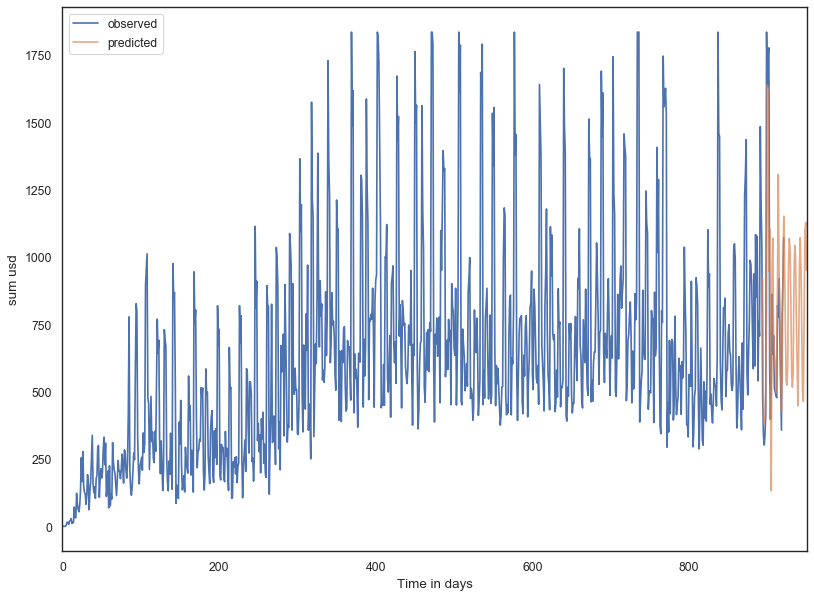

KeyError: 'true_sum'

In [59]:
start_p = df_contr.shape[0]  -cnt_weeks_to_self_predict*7 * 1
end_p = df_contr.shape[0]  + cnt_weeks_to_self_predict*7 * 1 # прогнозируем на 1 месяц вперед

#отрисуем результат
#with deviation
pred = model.get_prediction(start = start_p, end = end_p, dynamic=False)
pred_ci = pred.conf_int()
#without deviation
pred_vals = model.predict(start = start_p, end = end_p, dynamic=False)
pred_vals[pred_vals < 0] = 0

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

ax = df_contr['sum_transactions'].plot(label='observed')

pred_vals.plot(ax=ax, label='predicted', alpha=.7)
ax.set_xlabel('Time in days')
ax.set_ylabel('sum usd')
plt.legend()

plt.savefig('./images/'+str(i)+'_'+str(look_period)+'.jpg')
plt.show()

print('true',best_qp_dict['true_sum'])
print('predict',best_qp_dict['predict_sum'])

print('error rate: {0}'.format((best_qp_dict['predict_sum'] - best_qp_dict['true_sum'])/best_qp_dict['true_sum']))
